In [59]:
import numpy as np
import plotnine as pn
import pandas as pd

In [60]:
# Simulate an atlas as a collection of points
# For simplicity use the real line.

In [61]:
# Then assign dates to each paper using exponential distribution,
# such that newer papers are exponentially more likely

In [62]:
# Then simulate calculating prior density
# density = k / arccos( cos(p_i, p_k) )

In [63]:
# Then plot the histogram of density. Is it normally distributed?

Given that almost all of these steps are available in sciterra Atlas and Cartography, it's probably best to create dummy vectorizer and dummy publications.

I.e. create serizalized identifiers, dummy abstracts, and a vectorizer that randomly generates a number between 0 and 1 (which is therefore automatically normed).

In [64]:
from sciterra.vectorization.vectorizer import Vectorizer

class DummyVectorizer(Vectorizer):
    def embed_documents(self, docs: list[str], batch_size: int = 64) -> dict[str, np.ndarray]:
        # NOTE: the biggest predictor of skew in the distribution of density so far has actually been embedding dim! Low dimension leads to lognormal, anything 4 or higher leads to normal

        # embedding_dim = 768
        embedding_dim = 20 # for inspection

        embeddings = np.array([[np.random.rand() for _ in range(embedding_dim)] for _ in range(len(docs))])
        # norm to 1
        # embeddings_normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        return {
                "embeddings": embeddings,
                "success_indices": np.arange(len(docs)),
                "fail_indices": np.array([])
            }

# Test
vec = DummyVectorizer()
result = vec.embed_documents(["dummy_text"]*128)
result['embeddings'].shape

(128, 20)

In [65]:
# Generate dummy publications

from sciterra import Publication
from datetime import datetime

def get_dummy_pubs(num_pubs: int, year: int, start_idx: int = 0) -> list[Publication]:
    publications = [
        Publication(
            dict(
                identifier=f"{start_idx + idx}",
                publication_date=datetime(
                    year=year,
                    # Dummy month day
                    month=1,
                    day=1,
                )
            )
        )
        for idx in range(num_pubs)
    ]
    return publications

# Test
pubs = get_dummy_pubs(100, 2022)
pubs[0].__dict__

{'_identifier': '0',
 '_abstract': None,
 '_publication_date': datetime.datetime(2022, 1, 1, 0, 0),
 '_citation_count': None,
 '_fields_of_study': None,
 '_citations': [],
 '_references': []}

In [66]:
def exp_population_growth(initial_population, years):
    doubling_time = 16
    growth_rate = 2 ** (years / doubling_time)
    final_population = initial_population * growth_rate
    return int(final_population)

def lin_population_growth(initial_population, years):
    growth_rate = 10
    final_population = initial_population + growth_rate * years
    return int(final_population)

def log_population_growth(initial_population, years):
    max_population = 1000
    growth_rate = 0.1
    final_population = max_population / (1 + ((max_population / initial_population) - 1) * np.exp(-growth_rate * years))
    return int(final_population)

In [67]:
# Create population(s) of publications, dated 
initial_population = 100
start = 1990
end = 2020
years = range(start, end+1)

pubs: list[Publication] = []
idx = 0
for year in years:
    # num_pubs = exp_population_growth(initial_population, year - start)
    # num_pubs = lin_population_growth(initial_population, year - start)
    num_pubs = log_population_growth(initial_population, year - start)
    pubs.extend(get_dummy_pubs(num_pubs, year, idx))
    idx += num_pubs


In [68]:
vec = DummyVectorizer()
embeddings = vec.embed_documents(["dummy_doc"]*len(pubs))["embeddings"]
embeddings[0]

array([0.96705366, 0.37299331, 0.80773106, 0.27052275, 0.75742759,
       0.76885292, 0.9106275 , 0.93109864, 0.9614119 , 0.27038641,
       0.42903783, 0.614362  , 0.16054125, 0.73519414, 0.86594934,
       0.35498161, 0.86246536, 0.99005749, 0.63841037, 0.44259395])

In [69]:
from sciterra import Atlas
from sciterra.vectorization.projection import Projection

proj = Projection(
    identifier_to_index={pub.identifier:int(pub.identifier) for pub in pubs},
    index_to_identifier=tuple([pub.identifier for pub in pubs]),
    embeddings=embeddings,
)

atl = Atlas(
    publications=pubs,
    projection=proj,
)
len(atl)

11057

In [70]:
embeddings.shape

(11057, 20)

In [71]:
embeddings[0], embeddings[-1]

(array([0.96705366, 0.37299331, 0.80773106, 0.27052275, 0.75742759,
        0.76885292, 0.9106275 , 0.93109864, 0.9614119 , 0.27038641,
        0.42903783, 0.614362  , 0.16054125, 0.73519414, 0.86594934,
        0.35498161, 0.86246536, 0.99005749, 0.63841037, 0.44259395]),
 array([0.12632091, 0.37706709, 0.53746908, 0.37208639, 0.86468108,
        0.29035776, 0.5319222 , 0.75471039, 0.48682859, 0.5465003 ,
        0.0415384 , 0.54221865, 0.43153603, 0.0866256 , 0.15914943,
        0.90776123, 0.42904644, 0.45255703, 0.62717805, 0.08308566]))

In [72]:
# sanity check: 
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity(embeddings, embeddings)
sims[0]

array([1.        , 0.76907584, 0.72405152, ..., 0.77031892, 0.8116369 ,
       0.80878385])

In [73]:
# Use Cartographer to measure density. This might involve adding dummy publication dates :/

from sciterra.mapping.cartography import Cartographer

crt = Cartographer(vectorizer=vec)
densities = crt.measure_topography(
    atl,
)

computing cosine similarity for 11057 embeddings with batch size 1000.


100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


Computing ['density'] for 11057 publications.


100%|██████████| 11057/11057 [00:06<00:00, 1659.76it/s]


In [74]:
# Plot density distribution
data = pd.DataFrame(
    densities,
    columns=["density"],
)
data.dropna(inplace=True)
data

,density
100,24.793690
101,25.635066
102,22.303224
103,27.724183
104,25.762042
...,...
11052,41.603772
11053,39.513810
11054,37.867879
11055,42.009493


'stat_bin()' using 'bins = 59'. Pick better value with 'binwidth'.


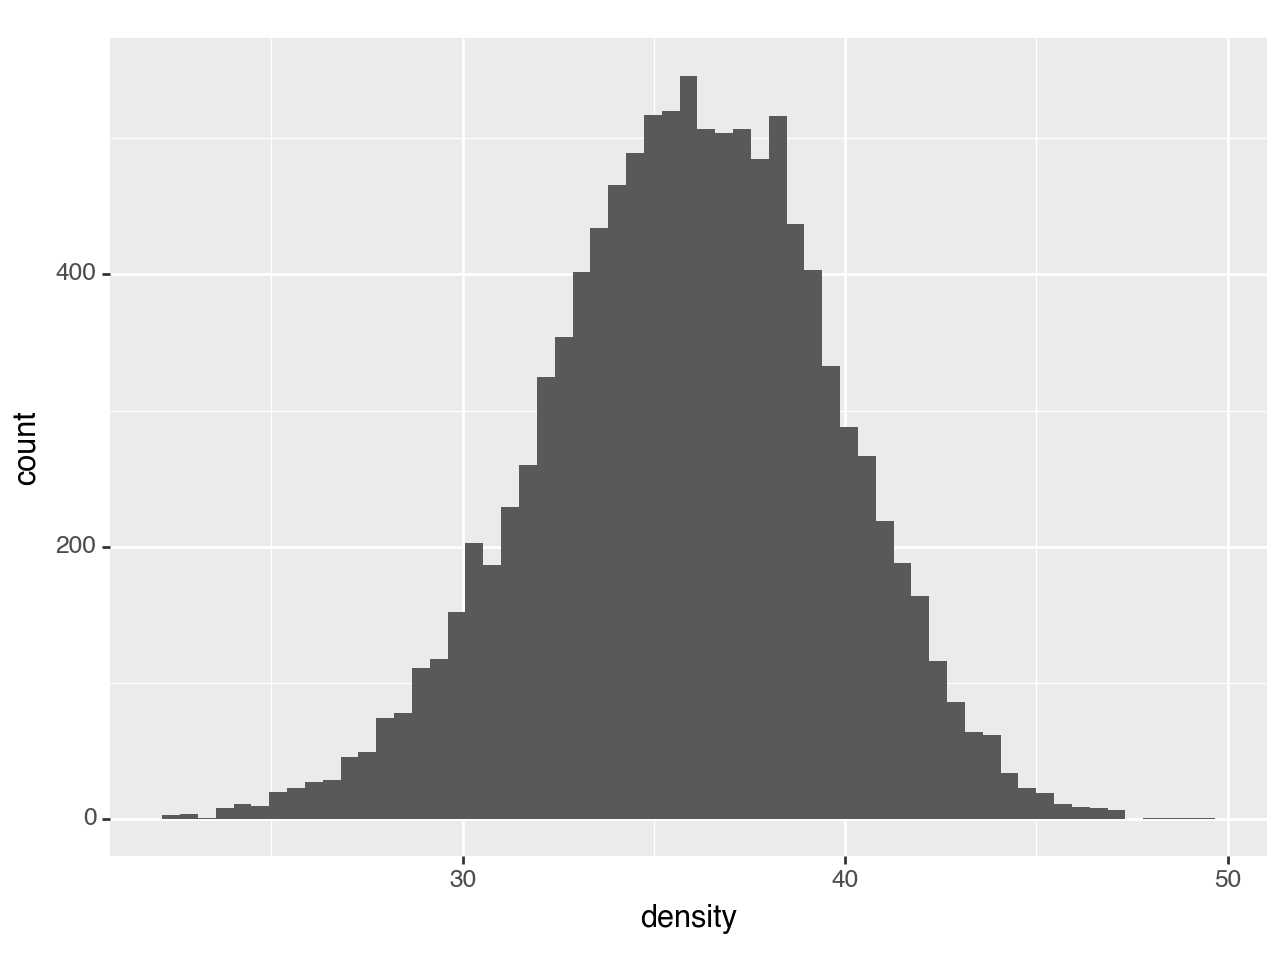

<Figure Size: (640 x 480)>

In [75]:
(
    pn.ggplot(
        data,
        pn.aes(x="density")
    )
    + pn.geom_histogram()
)

Next: simulate a more exploration-based/dirichlet process whereby each new publication added is close to the vector of a randomly sampled previous publication.

In [76]:
from tqdm import tqdm

seed_size = 1
initial_population = get_dummy_pubs(num_pubs=seed_size, year=1990)
embeddings = vec.embed_documents(["dummy_text"]*len(initial_population))["embeddings"]
dim = embeddings.shape[1]

for i, pub in enumerate(initial_population):
    pub.embedding = embeddings[0]

num_generations = 10
pubs = initial_population

sigma = 0.1

for gen_idx in tqdm(range(num_generations)):
    # lin pop growth was correct for plotting but it unintuitively gives an exponential total here so lets just do the simpler thing
    # num_pubs = lin_population_growth(len(initial_population), gen_idx)
    num_pubs = seed_size + gen_idx*100
    old_pubs = np.random.choice(pubs, size=num_pubs)

    new_pubs = []
    for idx in tqdm(range(num_pubs), desc=f"pubs for gen {gen_idx}"):
        pub = Publication(dict(
            identifier=f"dummy_pub_{gen_idx}_{idx}",
            publication_date=datetime(year=1990 + gen_idx, month=1, day=1),
        ))
        # Have to manually loop to add the embedding
        eps = np.random.normal(loc=0, scale=sigma, size=dim)
        new_emb = old_pubs[idx].embedding + eps
        # Norm
        # new_emb = new_emb / np.linalg.norm(new_emb)

        pub.embedding = new_emb
        new_pubs.append(pub)
    pubs.extend(new_pubs)

len(pubs)

100%|██████████| 10/10 [00:00<00:00, 108.19it/s]


4511

In [77]:
proj = Projection(
    identifier_to_index={pub.identifier:idx for idx, pub in enumerate(pubs)},
    index_to_identifier=tuple([pub.identifier for pub in pubs]),
    embeddings=np.vstack([pub.embedding for pub in pubs]),
)


atl = Atlas(
    publications=pubs,
    projection=proj,
)
len(atl)

4511

In [78]:
crt = Cartographer(vectorizer=vec)
densities = crt.measure_topography(
    atl,
)

# Plot density distribution
data = pd.DataFrame(
    densities,
    columns=["density"],
)
data.dropna(inplace=True)

computing cosine similarity for 4511 embeddings with batch size 1000.


100%|██████████| 5/5 [00:00<00:00, 25.57it/s]


Computing ['density'] for 4511 publications.


100%|██████████| 4511/4511 [00:01<00:00, 4209.95it/s]


'stat_bin()' using 'bins = 41'. Pick better value with 'binwidth'.


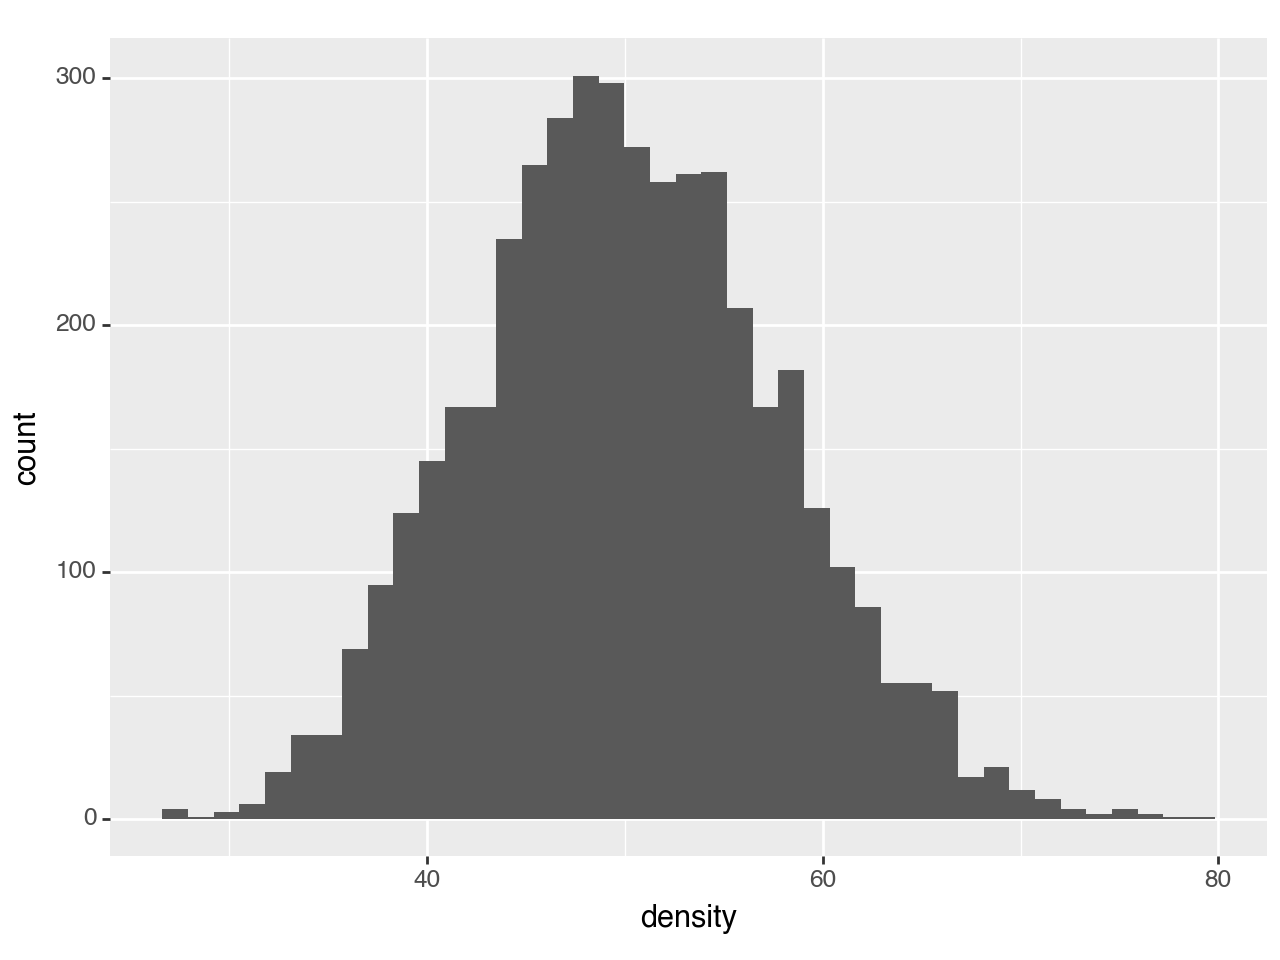

<Figure Size: (640 x 480)>

In [79]:
(
    pn.ggplot(
        data,
        pn.aes(x="density")
    )
    + pn.geom_histogram()
    # + pn.xlim(0,1000)
)

In [80]:
from sklearn.manifold import TSNE

embeddings = np.vstack([pub.embedding for pub in pubs])
embeddings_2d = embeddings

# # Apply t-SNE if dim > 2
embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

data = pd.DataFrame(
    embeddings_2d,
    columns=["dim1", "dim2"],
)
data["year"] = [pub.publication_date.year for pub in pubs]
(
    pn.ggplot(
        data,
        mapping=pn.aes(x="dim1", y="dim2"),
    )
    + pn.geom_point(
        alpha=0.1,
        mapping=pn.aes(
            color="year",
        ),
    )
)

ValueError: Shape of passed values is (4511, 20), indices imply (4511, 2)

'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


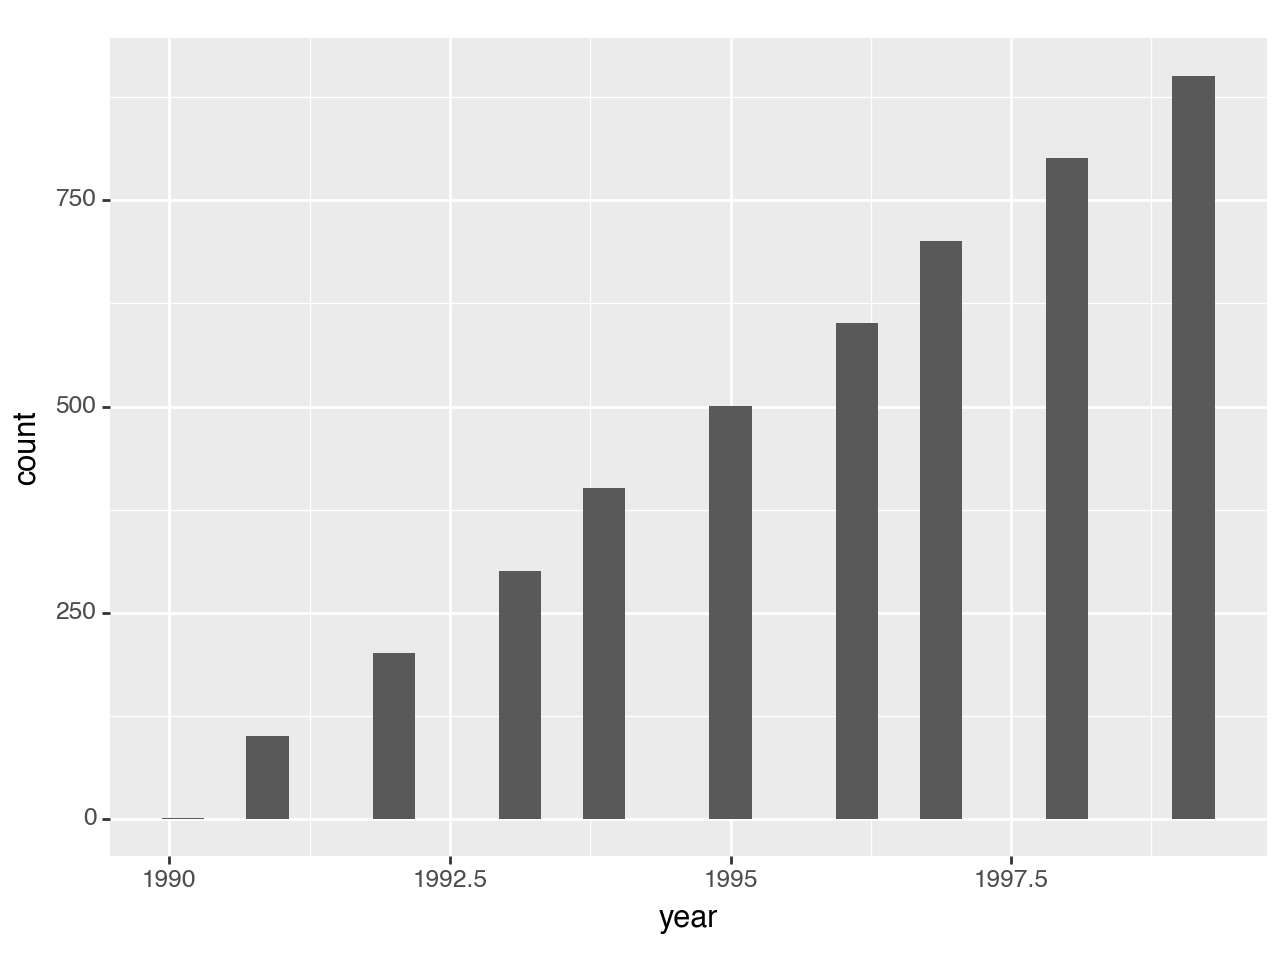

<Figure Size: (640 x 480)>

In [ ]:
# Sanity check: the distribution of dates matches the growth function we used

(
    pn.ggplot(
        pd.DataFrame(data["year"]),
        pn.aes(x="year")
    )
    + pn.geom_histogram()
)